<a href="https://colab.research.google.com/github/RaihanSubhan/Md-Raihan-Subhan/blob/main/Anomaly_Detection_OVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Get the current GPU device
    gpu_device = torch.cuda.get_device_name(0)
    print(f"Current GPU: {gpu_device}")
else:
    print("No GPU available.")


Current GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gputil


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=4cfa206d81dc0941473ee62dc47e4dc4afde93890367e935b31fc69b2000b703
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
import GPUtil

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

# Print information for each GPU
for gpu in gpus:
    print(f"GPU Model: {gpu.name}")
    print(f"GPU ID: {gpu.id}")
    print(f"GPU Memory Total: {gpu.memoryTotal} MB")
    print(f"GPU Memory Free: {gpu.memoryFree} MB")
    print(f"GPU Memory Used: {gpu.memoryUsed} MB")
    print(f"GPU Driver: {gpu.driver}")
    print("\n" + "="*30 + "\n")


GPU Model: Tesla T4
GPU ID: 0
GPU Memory Total: 15360.0 MB
GPU Memory Free: 15099.0 MB
GPU Memory Used: 3.0 MB
GPU Driver: 535.104.05




In [ ]:
!pip install psutil


In [ ]:
import psutil

# Get the total RAM in GB
ram_gb = psutil.virtual_memory().total / (1024 ** 3)

print(f"Total RAM: {ram_gb:.2f} GB")

Total RAM: 12.67 GB


# **Data Loading**

In [ ]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the dataset path
dataset_path = '/content/drive/MyDrive/Dataset/mvtec_loco_anomaly_detection'

# Set the input shape of the images
input_shape = (224, 224, 3)

# Set the batch size
batch_size = 32

# Function to get the defects_config file path for a specific class
def get_defects_config_path(class_name):
    return os.path.join(dataset_path, class_name, 'defects_config.json')

# Create ImageDataGenerator objects for train, validation, and test data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate train, validation, and test data generators for each class
classes = ['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']
train_generators = []
val_generators = []
test_generators = []

for class_name in classes:
    train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_path, class_name, 'train'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    train_generators.append(train_generator)

    val_generator = val_datagen.flow_from_directory(
        os.path.join(dataset_path, class_name, 'validation'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    val_generators.append(val_generator)

    test_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_path, class_name, 'test'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    test_generators.append(test_generator)

# Load the defects_config.json file for each class
defects_config_paths = [get_defects_config_path(class_name) for class_name in classes]
defects_configs = []
for path in defects_config_paths:
    with open(path) as f:
        defects_config = json.load(f)
        defects_configs.append(defects_config)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/breakfast_box/train'

# **VGG16 model Perprocess**

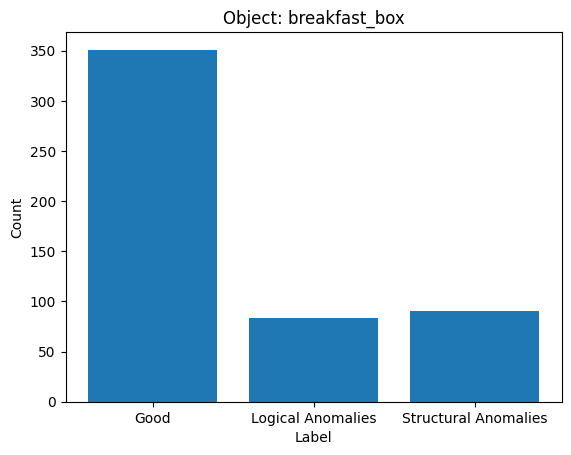

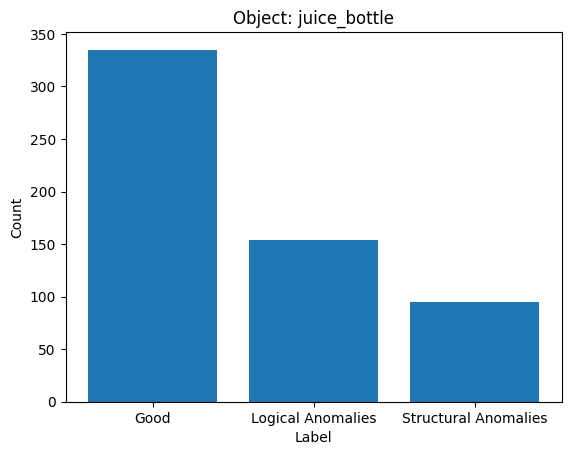

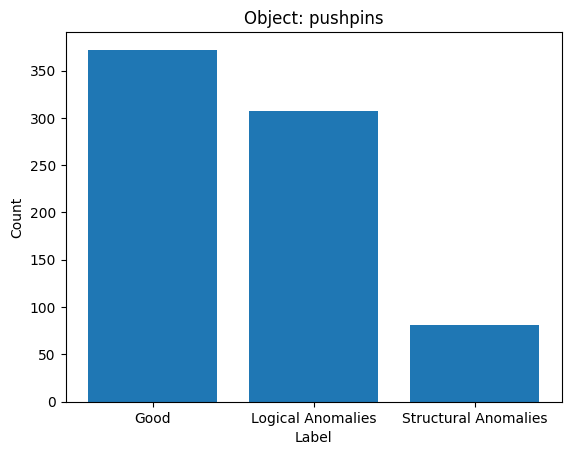

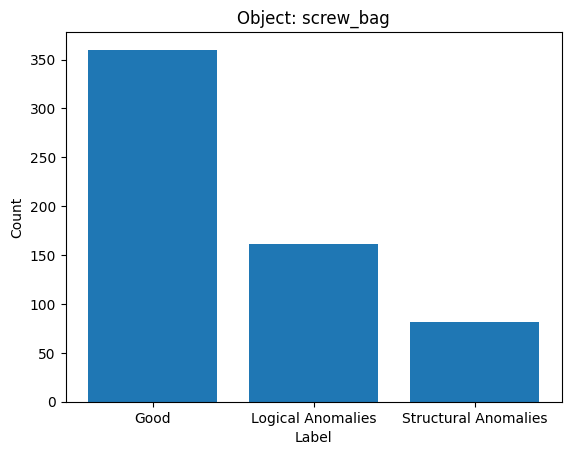

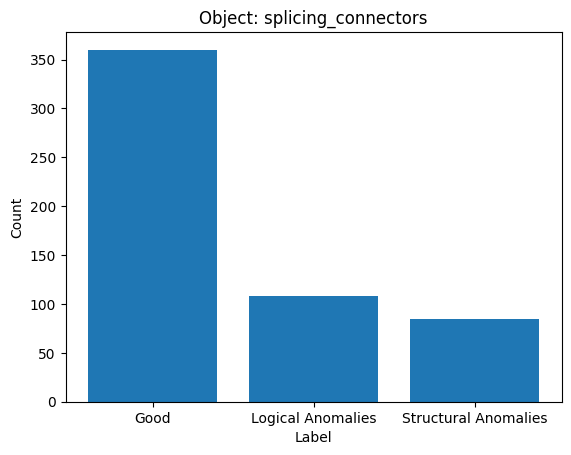

Total labeled images: 3024


In [ ]:
import os
import shutil
import matplotlib.pyplot as plt

dataset_path = '/content/drive/MyDrive/Dataset/mvtec_loco_anomaly_detection'
output_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'
os.makedirs(output_dir, exist_ok=True)

object_names = ['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']
total_labeled_images = 0

for object_name in object_names:
    object_path = os.path.join(dataset_path, object_name)
    labeled_object_path = os.path.join(output_dir, object_name)
    os.makedirs(labeled_object_path, exist_ok=True)

    # Process the 'good' images
    good_images_dir = os.path.join(object_path, 'train', 'good')
    good_output_dir = os.path.join(labeled_object_path, 'good')
    os.makedirs(good_output_dir, exist_ok=True)
    for file in os.listdir(good_images_dir):
        if file.endswith('.png'):
            src_path = os.path.join(good_images_dir, file)
            dst_path = os.path.join(good_output_dir, f'good_{file}')
            shutil.copyfile(src_path, dst_path)
            total_labeled_images += 1

    # Process the 'logical_anomalies' images
    logical_anomalies_dir = os.path.join(object_path, 'ground_truth', 'logical_anomalies')
    logical_output_dir = os.path.join(labeled_object_path, 'logical_anomalies')
    os.makedirs(logical_output_dir, exist_ok=True)
    for folder in os.listdir(logical_anomalies_dir):
        folder_path = os.path.join(logical_anomalies_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.png'):
                    src_path = os.path.join(folder_path, file)
                    dst_path = os.path.join(logical_output_dir, f'{object_name}_{folder}_{file}')
                    shutil.copyfile(src_path, dst_path)
                    total_labeled_images += 1

    # Process the 'structural_anomalies' images
    structural_anomalies_dir = os.path.join(object_path, 'ground_truth', 'structural_anomalies')
    structural_output_dir = os.path.join(labeled_object_path, 'structural_anomalies')
    os.makedirs(structural_output_dir, exist_ok=True)
    for folder in os.listdir(structural_anomalies_dir):
        folder_path = os.path.join(structural_anomalies_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.png'):
                    src_path = os.path.join(folder_path, file)
                    dst_path = os.path.join(structural_output_dir, f'{object_name}_{folder}_{file}')
                    shutil.copyfile(src_path, dst_path)
                    total_labeled_images += 1

    # Display the visual summary
    num_good_images = len(os.listdir(good_output_dir))
    num_logical_images = sum([len(files) for _, _, files in os.walk(logical_output_dir)])
    num_structural_images = sum([len(files) for _, _, files in os.walk(structural_output_dir)])

    plt.bar(['Good', 'Logical Anomalies', 'Structural Anomalies'],
            [num_good_images, num_logical_images, num_structural_images])
    plt.title(f'Object: {object_name}')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

print(f'Total labeled images: {total_labeled_images}')

# **Train**

**ResNet50**

In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'

# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Create the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  # Change activation to 'softmax'
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Create data generators for training and validation
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.4)
train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Update class_mode to 'sparse'
    subset='training'
)
val_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Update class_mode to 'sparse'
    subset='validation'
)


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

58889256/58889256 [==============================] - 4s 0us/step
Found 1816 images belonging to 5 classes.
Found 1208 images belonging to 5 classes.
Epoch 1/10
56/56 [==============================] - 2089s 37s/step - loss: 2.3451 - accuracy: 0.4294 - val_loss: 0.6474 - val_accuracy: 0.8522
Epoch 2/10
56/56 [==============================] - 149s 3s/step - loss: 0.8931 - accuracy: 0.6715 - val_loss: 0.2485 - val_accuracy: 0.9688
Epoch 3/10
56/56 [==============================] - 149s 3s/step - loss: 0.6065 - accuracy: 0.7640 - val_loss: 0.0616 - val_accuracy: 0.9941
Epoch 4/10
56/56 [==============================] - 201s 4s/step - loss: 0.4518 - accuracy: 0.8274 - val_loss: 0.0193 - val_accuracy: 0.9966
Epoch 5/10
56/56 [==============================] - 197s 4s/step - loss: 0.4210 - accuracy: 0.8447 - val_loss: 0.0263 - val_accuracy: 0.9983
Epoch 6/10
56/56 [==============================] - 195s 4s/step - loss: 0.3627 - accuracy: 0.8571 - val_loss: 0.0266 - val_accuracy: 0.9932
Epo

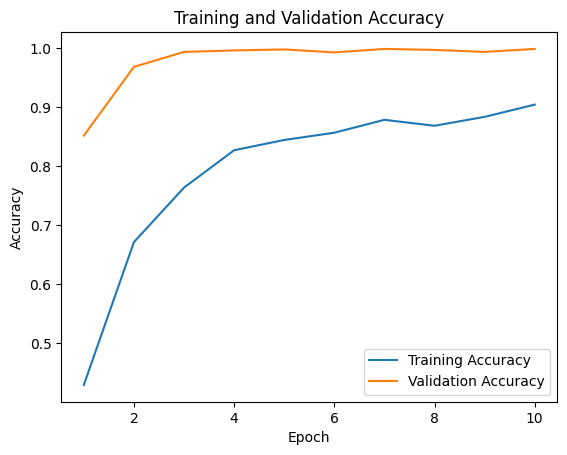

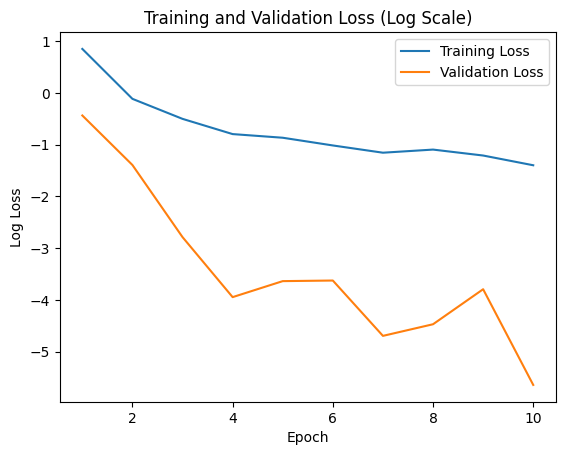

Best Validation Accuracy: 0.9992
Best Validation Loss: 0.0035
Total labeled images: 3024


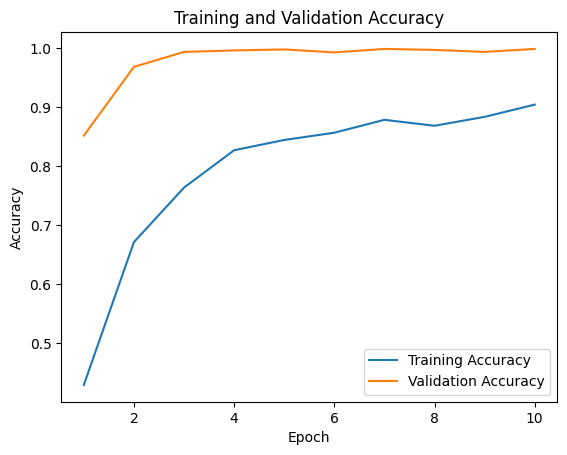

In [ ]:
# Plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss using a logarithmic scale
plt.plot(range(1, len(train_loss) + 1), np.log(train_loss), label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), np.log(val_loss), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.show()

# Create the accuracy plot
plt.figure()
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Save the accuracy plot as an image
plt.savefig('accuracy_plot.png', bbox_inches='tight')

# Calculate and display the best validation accuracy and loss
best_val_accuracy = max(val_accuracy)
best_val_loss = min(val_loss)
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')
print(f'Best Validation Loss: {best_val_loss:.4f}')

# Save the trained model
model.save('/content/drive/MyDrive/Dataset/vgg_model.h5')

print(f'Total labeled images: {total_labeled_images}')

# **Test**

# **VGG16**

Found 3024 images belonging to 5 classes.
95/95 [==============================] - 818s 9s/step
Classification Report:
                     precision    recall  f1-score   support

      breakfast_box       1.00      0.89      0.94       524
       juice_bottle       0.99      0.97      0.98       584
           pushpins       0.90      0.96      0.93       760
          screw_bag       0.88      0.96      0.92       603
splicing_connectors       0.97      0.91      0.94       553

           accuracy                           0.94      3024
          macro avg       0.95      0.94      0.94      3024
       weighted avg       0.94      0.94      0.94      3024



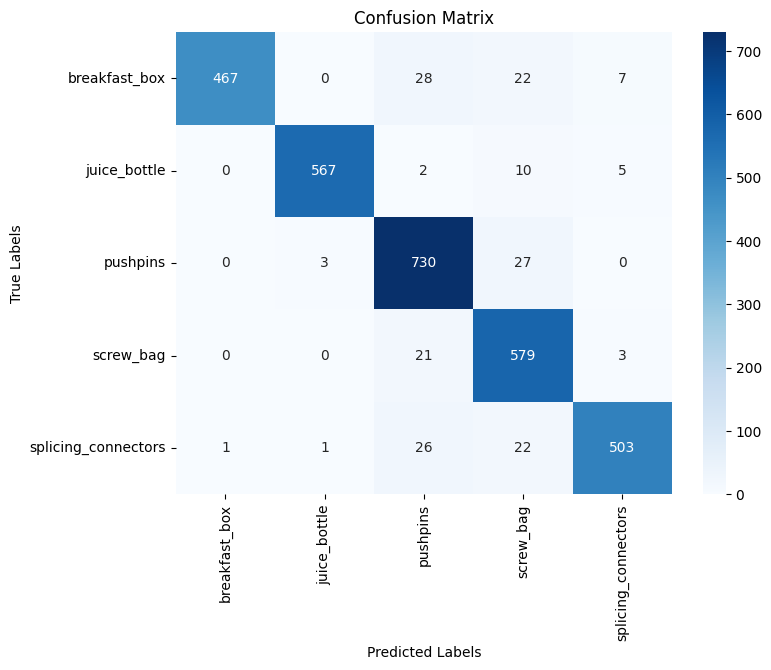

In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/vgg_model.h5')  # Update with the correct path to your trained model

# Create data generator for testing data
test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    subset='training',  # Use the training subset for testing
    shuffle=False  # Important to keep the order of predictions and ground truth labels
)

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and print classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the Confusion Matrix as an image with the bbox_inches='tight' parameter
plt.savefig('/content/confusion_matrix.png', bbox_inches='tight')

plt.show()


# **ROC**

95/95 [==============================] - 138s 1s/step
Accuracy for class 0: 0.98
Accuracy for class 1: 0.99
Accuracy for class 2: 0.96
Accuracy for class 3: 0.97
Accuracy for class 4: 0.98


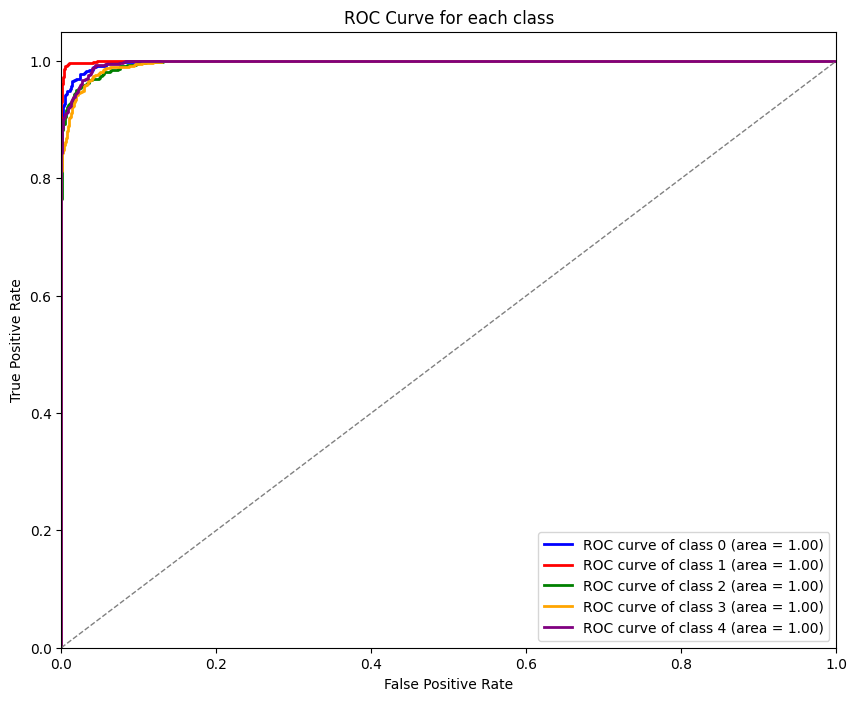

In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from itertools import cycle

# Assuming you have already defined test_generator, num_classes, and model

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)

# Compute accuracy for each class
predicted_labels = np.argmax(predictions, axis=1)

class_accuracy = {}
for i in range(num_classes):
    true_positive = np.sum((true_labels == i) & (predicted_labels == i))
    true_negative = np.sum((true_labels != i) & (predicted_labels != i))
    false_positive = np.sum((true_labels != i) & (predicted_labels == i))
    false_negative = np.sum((true_labels == i) & (predicted_labels != i))

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    class_accuracy[i] = accuracy
    print(f"Accuracy for class {i}: {accuracy:.2f}")

# Compute and plot ROC curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='lower right')

# Save the ROC curves plot as an image with the bbox_inches='tight' parameter
plt.savefig('/content/roc_curves.png', bbox_inches='tight')

plt.show()

# **Anomaly**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator for testing
test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Get the file names of the test data
file_names = test_generator.filenames

# Calculate the anomaly percentage
total_images = len(file_names)
anomaly_count = np.sum(y_pred != y_true)
anomaly_percentage = (anomaly_count / total_images) * 100

# Print the anomaly percentage
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')

# Get the names of the anomaly images
anomaly_names = []
for i in range(len(file_names)):
    if y_pred[i] != y_true[i]:
        anomaly_names.append(file_names[i])

# Print the names of the anomaly images
print('Anomaly Image Names:')
for name in anomaly_names:
    print(name)


Found 3024 images belonging to 5 classes.
95/95 [==============================] - 152s 2s/step
Anomaly Percentage: 2.05%
Anomaly Image Names:
breakfast_box/structural_anomalies/breakfast_box_000_000.png
breakfast_box/structural_anomalies/breakfast_box_003_000.png
breakfast_box/structural_anomalies/breakfast_box_009_000.png
breakfast_box/structural_anomalies/breakfast_box_011_000.png
breakfast_box/structural_anomalies/breakfast_box_019_000.png
breakfast_box/structural_anomalies/breakfast_box_031_000.png
breakfast_box/structural_anomalies/breakfast_box_034_000.png
breakfast_box/structural_anomalies/breakfast_box_039_000.png
breakfast_box/structural_anomalies/breakfast_box_042_000.png
breakfast_box/structural_anomalies/breakfast_box_047_000.png
breakfast_box/structural_anomalies/breakfast_box_049_000.png
breakfast_box/structural_anomalies/breakfast_box_058_000.png
breakfast_box/structural_anomalies/breakfast_box_063_000.png
breakfast_box/structural_anomalies/breakfast_box_064_000.png
bre

# **Anomaly Prediction Accuracy**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
test_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/vgg_model.h5')  # Update with the correct path to your trained model

# Create a data generator for testing
test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for numerical class labels
    shuffle=False
)

# Make predictions on the test data
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the anomaly percentage
total_images = len(true_labels)
anomaly_count = np.sum(predicted_labels != true_labels)
anomaly_percentage = (anomaly_count / total_images) * 100

# Print the anomaly percentage and accuracy
accuracy = (1 - (anomaly_count / total_images)) * 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')


Found 3024 images belonging to 5 classes.
95/95 [==============================] - 2221s 23s/step
Accuracy: 91.53%
Anomaly Percentage: 8.47%


# **SVM Data Preprocessing**

Total number of good images: 1778
Total number of logical anomalies: 813
Total number of structural anomalies: 433


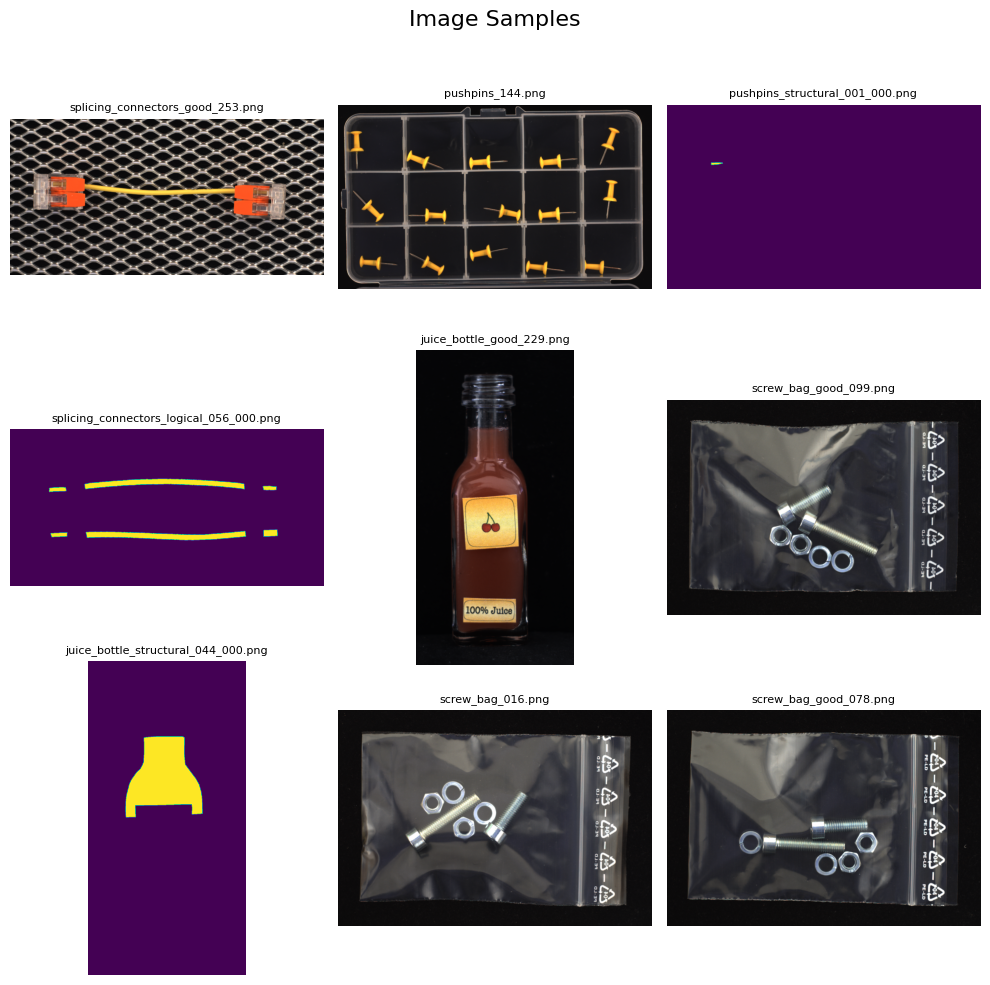

In [ ]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dataset_path = '/content/drive/MyDrive/Dataset/mvtec_loco_anomaly_detection'
object_names = ['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']
output_dir = '/content/drive/MyDrive/Dataset/good_images'
os.makedirs(output_dir, exist_ok=True)

# Count of good images and anomalies
good_images_count = 0
logical_anomalies_count = 0
structural_anomalies_count = 0

# Iterate over each object
for obj_name in object_names:
    obj_dir = os.path.join(dataset_path, obj_name)
    train_dir = os.path.join(obj_dir, 'train')
    validation_dir = os.path.join(obj_dir, 'validation')
    test_dir = os.path.join(obj_dir, 'test')

    # Move good images from train directory
    good_train_dir = os.path.join(train_dir, 'good')
    good_train_images = os.listdir(good_train_dir)
    for image in good_train_images:
        src_path = os.path.join(good_train_dir, image)
        dst_path = os.path.join(output_dir, f'{obj_name}_good_{image}')
        shutil.copy(src_path, dst_path)
        good_images_count += 1

    # Move logical anomalies images from ground_truth directory
    logical_anomalies_dir = os.path.join(obj_dir, 'ground_truth', 'logical_anomalies')
    logical_anomalies_images_list = os.listdir(logical_anomalies_dir)
    for folder in logical_anomalies_images_list:
        folder_path = os.path.join(logical_anomalies_dir, folder)
        images = os.listdir(folder_path)
        for image in images:
            src_path = os.path.join(folder_path, image)
            dst_path = os.path.join(output_dir, f'{obj_name}_logical_{folder}_{image}')
            shutil.copy(src_path, dst_path)
            logical_anomalies_count += 1

    # Move structural anomalies images from ground_truth directory
    structural_anomalies_dir = os.path.join(obj_dir, 'ground_truth', 'structural_anomalies')
    structural_anomalies_images_list = os.listdir(structural_anomalies_dir)
    for folder in structural_anomalies_images_list:
        folder_path = os.path.join(structural_anomalies_dir, folder)
        images = os.listdir(folder_path)
        for image in images:
            src_path = os.path.join(folder_path, image)
            dst_path = os.path.join(output_dir, f'{obj_name}_structural_{folder}_{image}')
            shutil.copy(src_path, dst_path)
            structural_anomalies_count += 1

# Print the count of good images and anomalies
print(f'Total number of good images: {good_images_count}')
print(f'Total number of logical anomalies: {logical_anomalies_count}')
print(f'Total number of structural anomalies: {structural_anomalies_count}')

# Display a random sample of good images, logical anomalies, and structural anomalies
num_images = 9
display_images = random.sample(os.listdir(output_dir), num_images)

# Create a grid of subplots to display the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

# Set the title of the output
fig.suptitle('Image Samples', fontsize=16)

# Iterate over each image and display it in a subplot
for i, image_name in enumerate(display_images):
    row = i // 3
    col = i % 3
    image_path = os.path.join(output_dir, image_name)
    img = mpimg.imread(image_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(image_name, fontsize=8)
    axes[row, col].set_aspect('equal')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.show()


# **SVM Train**

<ipython-input-5-270421f828d1>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features_list)


Test Accuracy: 0.6429


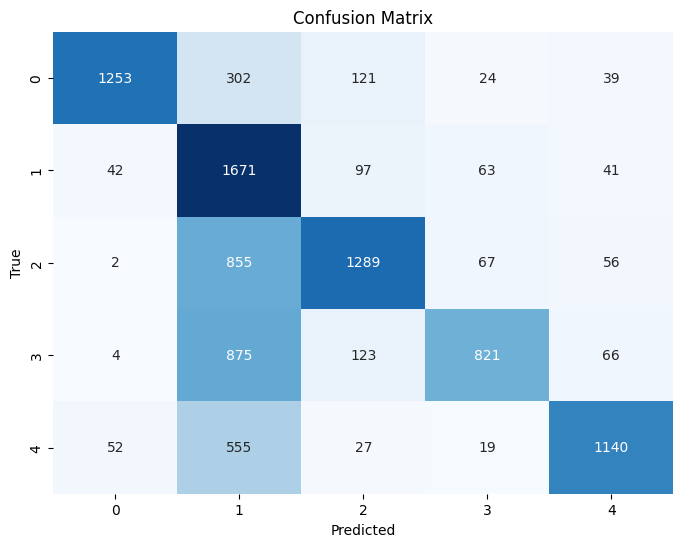

In [ ]:
# Define the lists to store features and labels
features_list = []
labels_list = []

# Set the maximum number of patches per image
max_patches_per_image = 10

# Set the patch size
patch_size = (16, 16)

# Iterate over the dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image and extract features
        image_path = os.path.join(root, file)
        image = mpimg.imread(image_path)
        patches = extract_patches_2d(image, patch_size, max_patches=max_patches_per_image)
        if len(patches) < max_patches_per_image:
            continue
        for patch in patches:
            features_list.append(patch.flatten())
            labels_list.append(file.split('_')[0])  # Set label as the object name

# Convert features and labels to numpy arrays
features = np.array(features_list)
labels = np.array(labels_list)

# Determine the maximum feature size
max_feature_size = max(feature.shape[0] for feature in features)

# Pad the features to have a consistent size
padded_features = np.zeros((len(features), max_feature_size))
for i, feature in enumerate(features):
    padded_features[i, :feature.shape[0]] = feature

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_features, labels, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

# Create an SVM classifier
svm_clf = svm.SVC(decision_function_shape='ovr')

# Train the SVM classifier
svm_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **SVM Test**

<ipython-input-8-b62179365117>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features_list)


Test Accuracy: 0.6353
Precision: 0.7432
Recall: 0.6353
F1-score: 0.6494


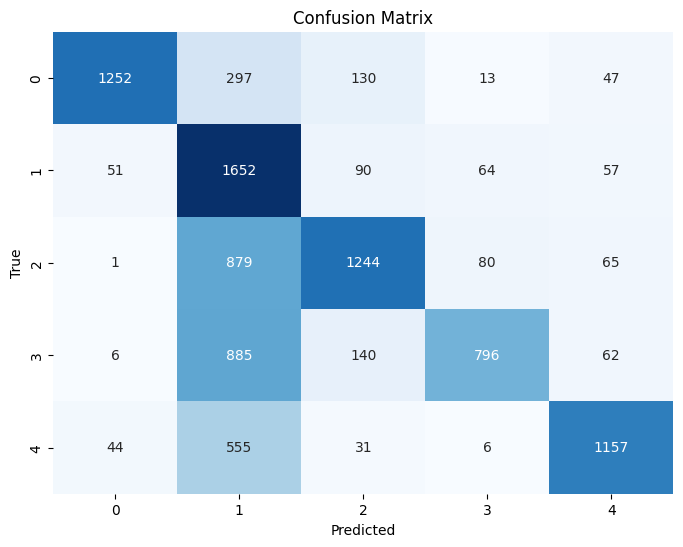

In [ ]:
# Define the lists to store features and labels
features_list = []
labels_list = []

# Set the maximum number of patches per image
max_patches_per_image = 10

# Set the patch size
patch_size = (16, 16)

# Iterate over the dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image and extract features
        image_path = os.path.join(root, file)
        image = mpimg.imread(image_path)
        patches = extract_patches_2d(image, patch_size, max_patches=max_patches_per_image)
        if len(patches) < max_patches_per_image:
            continue
        for patch in patches:
            features_list.append(patch.flatten())
            labels_list.append(file.split('_')[0])  # Set label as the object name

# Convert features and labels to numpy arrays
features = np.array(features_list)
labels = np.array(labels_list)

# Determine the maximum feature size
max_feature_size = max(feature.shape[0] for feature in features)

# Pad the features to have a consistent size
padded_features = np.zeros((len(features), max_feature_size))
for i, feature in enumerate(features):
    padded_features[i, :feature.shape[0]] = feature

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_features, labels, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

# Create an SVM classifier
svm_clf = svm.SVC(decision_function_shape='ovr')

# Train the SVM classifier
svm_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **RESNET50**

# **Train**

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Create a data generator for training
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' instead of 'categorical'
    subset='training'
)

val_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' instead of 'categorical'
    subset='validation'
)

# Create the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

# Save the trained model
model.save('/content/drive/MyDrive/Dataset/resnet_model.h5')


Found 1816 images belonging to 5 classes.
Found 1208 images belonging to 5 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
56/56 [==============================] - 1020s 17s/step - loss: 1.3007 - accuracy: 0.6143 - val_loss: 1476.6350 - val_accuracy: 0.2002
Epoch 2/10
56/56 [==============================] - 188s 3s/step - loss: 0.8069 - accuracy: 0.7068 - val_loss: 4.3120 - val_accuracy: 0.1850
Epoch 3/10
56/56 [==============================] - 230s 4s/step - loss: 0.6615 - accuracy: 0.7719 - val_loss: 2.1267 - val_accuracy: 0.2492
Epoch 4/10
56/56 [==============================] - 222s 4s/step - loss: 0.5887 - accuracy: 0.7876 - val_loss: 5.9323 - val_accuracy: 0.2542
Epoch 5/10
56/56 [==============================] - 225s 4s/step - loss: 0.5449 - accuracy: 0.8100 - val_loss: 3.3736 - val_accuracy: 0.2534
Epoch 6/10
56/56 [==============================] - 222s 4s/step - loss: 0.4920 - accuracy: 0.8296 - val_loss: 3.0432 - val_accuracy: 0.2517


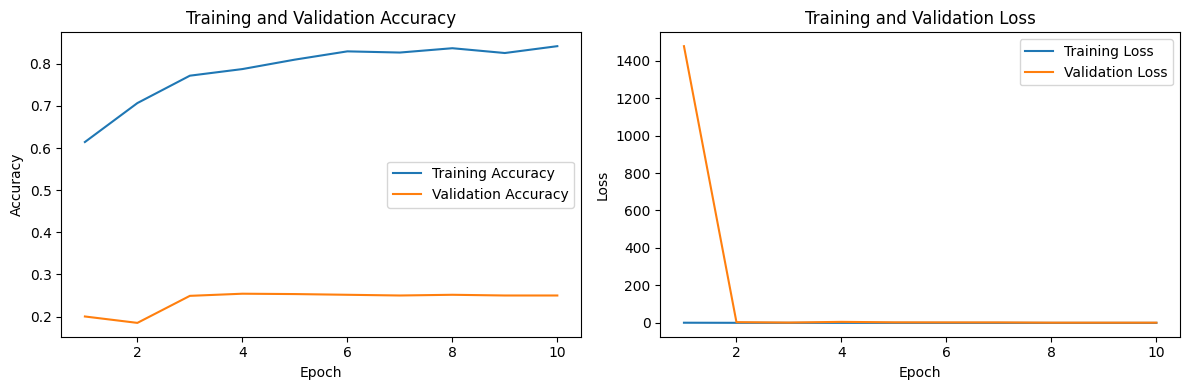

In [ ]:
# Plot the training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# **Test**

Found 3024 images belonging to 5 classes.
95/95 [==============================] - 139s 1s/step
Classification Report:
                     precision    recall  f1-score   support

      breakfast_box       0.98      0.86      0.92       524
       juice_bottle       0.92      0.99      0.95       584
           pushpins       0.94      0.98      0.96       760
          screw_bag       0.87      0.95      0.90       603
splicing_connectors       0.99      0.86      0.92       553

           accuracy                           0.93      3024
          macro avg       0.94      0.93      0.93      3024
       weighted avg       0.94      0.93      0.93      3024



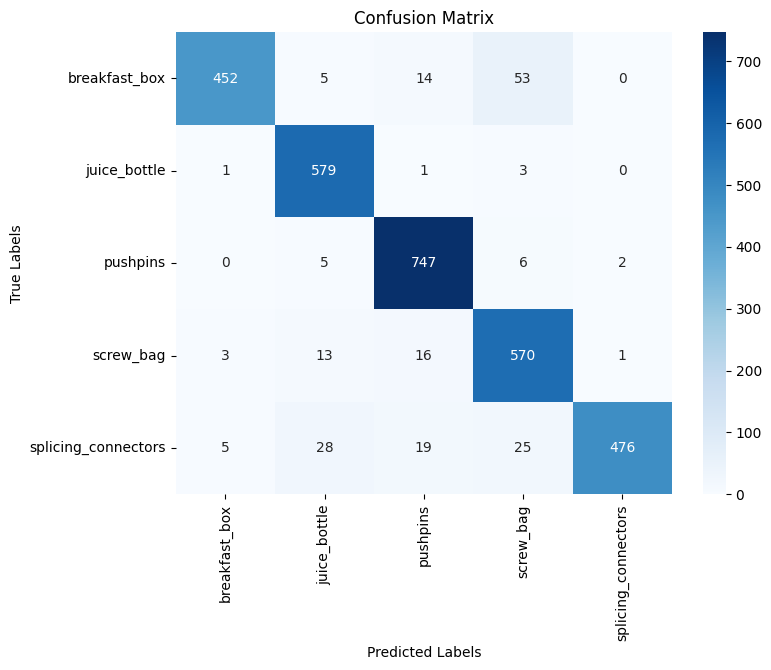

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/resnet_model.h5')  # Update with the correct path to your trained model

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and print classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the Confusion Matrix as an image with the bbox_inches='tight' parameter
plt.savefig('/content/resnet_confusion_matrix.png', bbox_inches='tight')

plt.show()


# **ROC**

95/95 [==============================] - 150s 2s/step


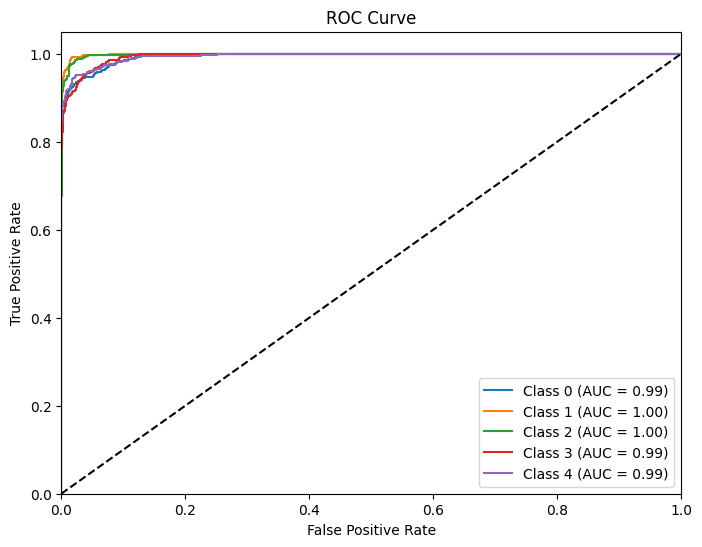

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/resnet_model.h5')  # Update with the correct path to your trained model

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.savefig('/content/resnet_roc_curve.png')
plt.show()


# **Anomaly Prediction**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5
# Define the path to the labeled dataset directory
test_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'
# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/resnet_model.h5')
# Make predictions on the test data
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
# Calculate the anomaly percentage
total_images = len(true_labels)
anomaly_count = np.sum(predicted_labels != true_labels)
anomaly_percentage = (anomaly_count / total_images) * 100
# Print the anomaly percentage and accuracy
accuracy = (1 - (anomaly_count / total_images)) * 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')

95/95 [==============================] - 149s 2s/step
Accuracy: 93.39%
Anomaly Percentage: 6.61%


# **Inception_Net_V3**


# **Train**

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Create a data generator for training
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' instead of 'categorical'
    subset='training'
)

val_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' instead of 'categorical'
    subset='validation'
)

# Create the InceptionNet model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

# Save the trained model
model.save('/content/drive/MyDrive/Dataset/inception_model.h5')


Found 1816 images belonging to 5 classes.
Found 1208 images belonging to 5 classes.
Epoch 1/10
56/56 [==============================] - 217s 3s/step - loss: 0.8686 - accuracy: 0.6911 - val_loss: 1560.6926 - val_accuracy: 0.1993
Epoch 2/10
56/56 [==============================] - 216s 4s/step - loss: 0.6496 - accuracy: 0.7831 - val_loss: 14.7247 - val_accuracy: 0.3775
Epoch 3/10
56/56 [==============================] - 175s 3s/step - loss: 0.5078 - accuracy: 0.8296 - val_loss: 4.2959 - val_accuracy: 0.7145
Epoch 4/10
56/56 [==============================] - 182s 3s/step - loss: 0.5063 - accuracy: 0.8251 - val_loss: 6.7102 - val_accuracy: 0.5448
Epoch 5/10
56/56 [==============================] - 171s 3s/step - loss: 0.4981 - accuracy: 0.8292 - val_loss: 5.2532 - val_accuracy: 0.5574
Epoch 6/10
56/56 [==============================] - 170s 3s/step - loss: 0.4369 - accuracy: 0.8459 - val_loss: 0.3564 - val_accuracy: 0.9341
Epoch 7/10
56/56 [==============================] - 169s 3s/step -

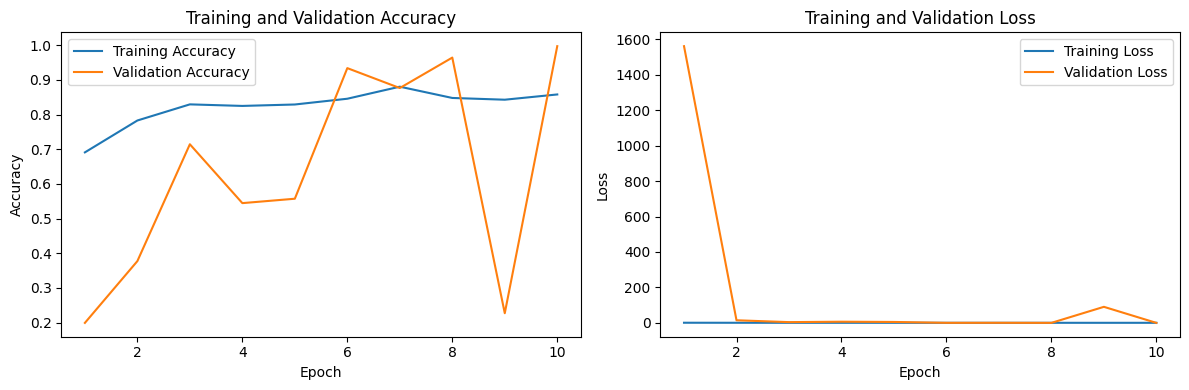

In [ ]:
# Plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

## **Test**

Found 3024 images belonging to 5 classes.
95/95 [==============================] - 142s 1s/step
Classification Report:
                     precision    recall  f1-score   support

      breakfast_box       0.98      0.86      0.92       524
       juice_bottle       0.92      0.99      0.95       584
           pushpins       0.94      0.98      0.96       760
          screw_bag       0.87      0.95      0.90       603
splicing_connectors       0.99      0.86      0.92       553

           accuracy                           0.93      3024
          macro avg       0.94      0.93      0.93      3024
       weighted avg       0.94      0.93      0.93      3024



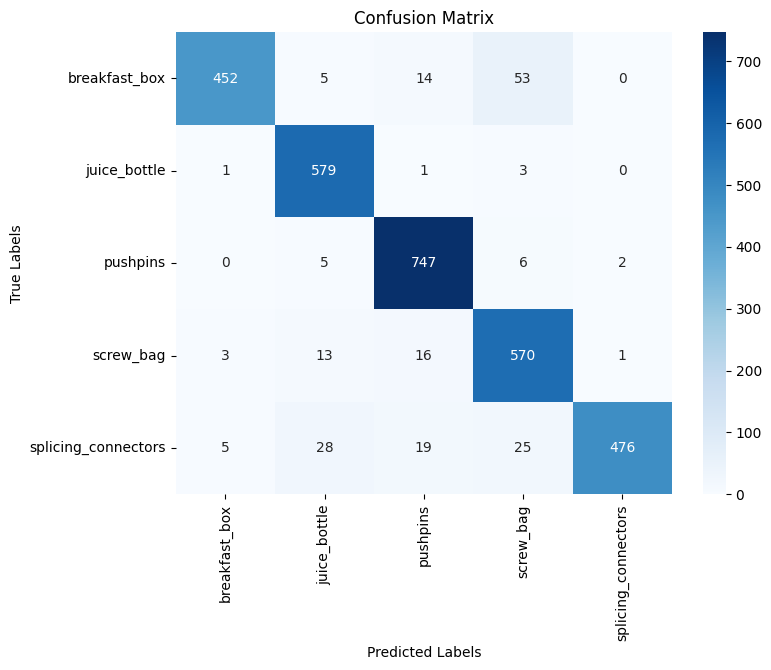

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/inception_model.h5')  # Update with the correct path to your trained model

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and print classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the Confusion Matrix as an image with the bbox_inches='tight' parameter
plt.savefig('/content/inception_confusion_matrix.png', bbox_inches='tight')

plt.show()


# **ROC**

95/95 [==============================] - 165s 2s/step


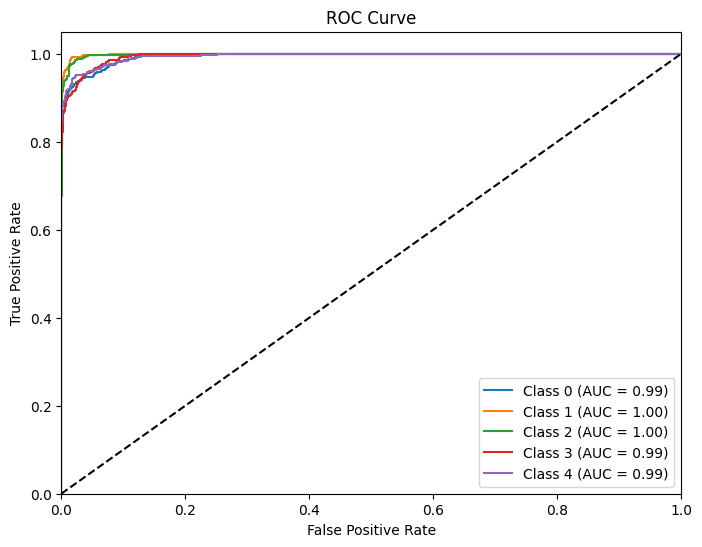

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
train_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/inception_model.h5')  # Update with the correct path to your trained model

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.savefig('/content/inception_roc_curve.png')
plt.show()


# **Anomaly Prediction**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
test_data_dir = '/content/drive/MyDrive/Dataset/labeled_dataset'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/inception_model.h5')  # Update with the correct path to your trained model

# Make predictions on the test data
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the anomaly percentage
total_images = len(true_labels)
anomaly_count = np.sum(predicted_labels != true_labels)
anomaly_percentage = (anomaly_count / total_images) * 100

# Print the anomaly percentage and accuracy
accuracy = (1 - (anomaly_count / total_images)) * 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')


95/95 [==============================] - 161s 2s/step
Accuracy: 93.39%
Anomaly Percentage: 6.61%


# **MVtec New dataset Peprocess**

In [ ]:
import os
import shutil

# Class information for train_val_data
train_val_class_info = {
    'bottle': {
        'ground_truth': {
            'broken_large': {},
            'broken_small': {},
            'contamination': {},
        },
        'train': {
            'good': {},
        },
    },
    'cable': {
        'ground_truth': {
            'bent_wire': {},
            'cable_swap': {},
            'combined': {},
            'cut_inner_insulation': {},
            'cut_outer_insulation': {},
            'missing_cable': {},
            'missing_wire': {},
            'poke_insulation': {},
        },
        'train': {
            'good': {},
        },
    },
    'capsule': {
        'ground_truth': {
            'crack': {},
            'faulty_imprint': {},
            'poke': {},
            'scratch': {},
            'squeeze': {},
        },
        'train': {
            'good': {},
        },
    },
    'carpet': {
        'ground_truth': {
            'color': {},
            'cut': {},
            'hole': {},
            'metal_contamination': {},
            'thread': {},
        },
        'train': {
            'good': {},
        },
    },
    'grid': {
        'ground_truth': {
            'bent': {},
            'broken': {},
            'glue': {},
            'metal_contamination': {},
            'thread': {},
        },
        'train': {
            'good': {},
        },
    },
    'hazelnut': {
        'ground_truth': {
            'crack': {},
            'cut': {},
            'hole': {},
            'print': {},
        },
        'train': {
            'good': {},
        },
    },
    'leather': {
        'ground_truth': {
            'color': {},
            'cut': {},
            'fold': {},
            'glue': {},
            'poke': {},
        },
        'train': {
            'good': {},
        },
    },
    'metal_nut': {
        'ground_truth': {
            'bent': {},
            'color': {},
            'flip': {},
            'scratch': {},
        },
        'train': {
            'good': {},
        },
    },
    'pill': {
        'ground_truth': {
            'color': {},
            'combined': {},
            'contamination': {},
            'crack': {},
            'faulty_imprint': {},
            'pill_type': {},
            'scratch': {},
        },
        'train': {
            'good': {},
        },
    },
    'screw': {
        'ground_truth': {
            'manipulated_front': {},
            'scratch_head': {},
            'scratch_neck': {},
            'thread_side': {},
            'thread_top': {},
        },
        'train': {
            'good': {},
        },
    },
    'tile': {
        'ground_truth': {
            'crack': {},
            'glue_strip': {},
            'gray_stroke': {},
            'oil': {},
            'rough': {},
        },
        'train': {
            'good': {},
        },
    },
    'toothbrush': {
        'ground_truth': {
            'defective': {},
        },
        'train': {
            'good': {},
        },
    },
    'transistor': {
        'ground_truth': {
            'bent_lead': {},
            'cut_lead': {},
            'damaged_case': {},
            'misplaced': {},
        },
        'train': {
            'good': {},
        },
    },
    'wood': {
        'ground_truth': {
            'color': {},
            'combined': {},
            'hole': {},
            'liquid': {},
            'scratch': {},
        },
        'train': {
            'good': {},
        },
    },
    'zipper': {
        'ground_truth': {
            'broken_teeth': {},
            'combined': {},
            'fabric_border': {},
            'fabric_interior': {},
            'rough': {},
            'split_teeth': {},
            'squeezed_teeth': {},
        },
        'train': {
            'good': {},
        },
    },
}


# Class information for test_data
test_class_info = {
    'bottle': {
        'test': {
            'broken_large': {},
            'broken_small': {},
            'contamination': {},
            'good': {},
        },
    },
    'cable': {
        'test': {
            'bent_wire': {},
            'cable_swap': {},
            'combined': {},
            'cut_inner_insulation': {},
            'cut_outer_insulation': {},
            'missing_cable': {},
            'missing_wire': {},
            'poke_insulation': {},
            'good': {},
        },
    },
    'capsule': {
        'test': {
            'crack': {},
            'faulty_imprint': {},
            'good': {},
            'poke': {},
            'scratch': {},
            'squeeze': {},
        },
    },
    'carpet': {
        'test': {
            'color': {},
            'cut': {},
            'good': {},
            'hole': {},
            'metal_contamination': {},
            'thread': {},
        },
    },
    'grid': {
        'test': {
            'bent': {},
            'broken': {},
            'glue': {},
            'good': {},
            'metal_contamination': {},
            'thread': {},
        },
    },
    'hazelnut': {
        'test': {
            'crack': {},
            'cut': {},
            'good': {},
            'hole': {},
            'print': {},
        },
    },
    'leather': {
        'test': {
            'color': {},
            'cut': {},
            'fold': {},
            'glue': {},
            'good': {},
            'poke': {},
        },
    },
    'metal_nut': {
        'test': {
            'bent': {},
            'color': {},
            'flip': {},
            'good': {},
            'scratch': {},
        },
    },
    'pill': {
        'test': {
            'color': {},
            'combined': {},
            'contamination': {},
            'crack': {},
            'faulty_imprint': {},
            'good': {},
            'pill_type': {},
            'scratch': {},
        },
    },
    'screw': {
        'test': {
            'good': {},
            'manipulated_front': {},
            'scratch_head': {},
            'scratch_neck': {},
            'thread_side': {},
            'thread_top': {},
        },
    },
    'tile': {
        'test': {
            'crack': {},
            'glue_strip': {},
            'good': {},
            'gray_stroke': {},
            'oil': {},
            'rough': {},
        },
    },
    'toothbrush': {
        'test': {
            'defective': {},
            'good': {},
        },
    },
    'transistor': {
        'test': {
            'bent_lead': {},
            'cut_lead': {},
            'damaged_case': {},
            'good': {},
            'misplaced': {},
        },
    },
    'wood': {
        'test': {
            'color': {},
            'combined': {},
            'good': {},
            'hole': {},
            'liquid': {},
            'scratch': {},
        },
    },
    'zipper': {
        'test': {
            'broken_teeth': {},
            'combined': {},
            'fabric_border': {},
            'fabric_interior': {},
            'good': {},
            'rough': {},
            'split_teeth': {},
            'squeezed_teeth': {},
        },
    },
}

# Define dataset paths
dataset_path = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection'
train_val_path = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'
test_path = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Inside the preprocess_class_data function
def preprocess_class_data(class_info, src_prefix, dst_prefix):
    total_samples = 0
    total_png_count = 0  # Total PNG file count for this data type

    for class_name, subdirs in class_info.items():
        for subdir, items in subdirs.items():
            src_dir = os.path.join(dataset_path, src_prefix, class_name, subdir)
            dst_dir = os.path.join(dst_prefix, class_name, subdir)
            os.makedirs(dst_dir, exist_ok=True)

            subdir_png_count = 0  # Count of PNG files in the current subdir
            print(f"Processing Class: {class_name}, Subdir: {subdir}")

            for item in items.keys():
                src_subdir = os.path.join(src_dir, item)
                dst_subdir = os.path.join(dst_dir, item)
                os.makedirs(dst_subdir, exist_ok=True)
                filenames = os.listdir(src_subdir)
                png_files = [filename for filename in filenames if filename.lower().endswith('.png')]
                subdir_png_count += len(png_files)  # Count PNG files in this subdir

                print(f"Class: {class_name}, Subdir: {subdir}, Item: {item}, Files: {png_files}")

                for filename in png_files:
                    src_file = os.path.join(src_subdir, filename)
                    dst_file = os.path.join(dst_subdir, filename)
                    if not os.path.exists(dst_file):
                        print(f"Copying {src_file} to {dst_file}")
                        shutil.copy(src_file, dst_file)
                        total_samples += 1

            print(f"Subdir '{subdir}' PNG count: {subdir_png_count}")
            total_png_count += subdir_png_count  # Accumulate subdir PNG count

    return total_samples, total_png_count

# Preprocess train_val_data
total_train_val_samples, total_train_val_png = preprocess_class_data(train_val_class_info, 'train_val_data', train_val_path)

# Preprocess test_data
total_test_samples, total_test_png = preprocess_class_data(test_class_info, 'test_data', test_path)

print("Dataset preprocessing completed.")
print(f"Total train+validation samples: {total_train_val_png}")
print(f"Total test samples: {total_test_png}")


Processing Class: bottle, Subdir: ground_truth
Class: bottle, Subdir: ground_truth, Item: broken_large, Files: ['019_mask.png', '000_mask.png', '017_mask.png', '012_mask.png', '004_mask.png', '009_mask.png', '018_mask.png', '002_mask.png', '013_mask.png', '011_mask.png', '016_mask.png', '010_mask.png', '006_mask.png', '003_mask.png', '008_mask.png', '015_mask.png', '014_mask.png', '007_mask.png', '005_mask.png', '001_mask.png']
Class: bottle, Subdir: ground_truth, Item: broken_small, Files: ['012_mask.png', '018_mask.png', '010_mask.png', '002_mask.png', '004_mask.png', '011_mask.png', '017_mask.png', '020_mask.png', '021_mask.png', '000_mask.png', '014_mask.png', '008_mask.png', '007_mask.png', '005_mask.png', '013_mask.png', '016_mask.png', '009_mask.png', '019_mask.png', '006_mask.png', '015_mask.png', '003_mask.png', '001_mask.png']
Class: bottle, Subdir: ground_truth, Item: contamination, Files: ['001_mask.png', '000_mask.png', '018_mask.png', '016_mask.png', '013_mask.png', '017_

# **VGG16**

# **Train**

Found 4887 images belonging to 15 classes.
Epoch 1/10
152/152 [==============================] - 166s 1s/step - loss: 1.9691 - accuracy: 0.4008
Epoch 2/10
152/152 [==============================] - 161s 1s/step - loss: 0.7912 - accuracy: 0.7469
Epoch 3/10
152/152 [==============================] - 163s 1s/step - loss: 0.5567 - accuracy: 0.8231
Epoch 4/10
152/152 [==============================] - 160s 1s/step - loss: 0.5411 - accuracy: 0.8255
Epoch 5/10
152/152 [==============================] - 161s 1s/step - loss: 0.5148 - accuracy: 0.8393
Epoch 6/10
152/152 [==============================] - 162s 1s/step - loss: 0.4358 - accuracy: 0.8556
Epoch 7/10
152/152 [==============================] - 160s 1s/step - loss: 0.3737 - accuracy: 0.8744
Epoch 8/10
152/152 [==============================] - 159s 1s/step - loss: 0.4464 - accuracy: 0.8579
Epoch 9/10
152/152 [==============================] - 162s 1s/step - loss: 0.7254 - accuracy: 0.7934
Epoch 10/10
152/152 [===========================

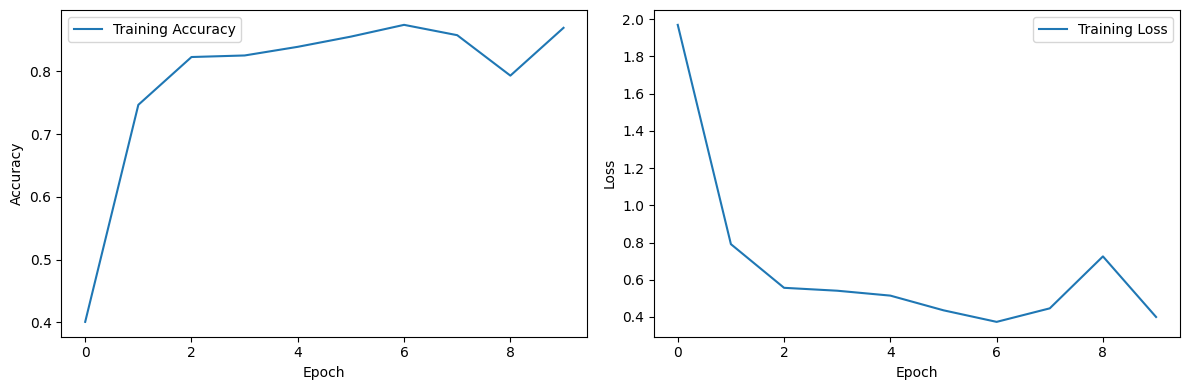

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'
model_save_path = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/vgg16_model.h5'

# Define the input shape and number of classes
input_shape = (224, 224, 3)
object_names = os.listdir(data_dir)  # List of class names
num_classes = len(object_names)

# Create the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Create data generator with minimal data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply VGG16-specific preprocessing
)

# Generate data
generator = datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
)

# Train the model
history = model.fit(
    generator,
    steps_per_epoch=generator.samples // generator.batch_size,
    epochs=10
)

# Save the model
model.save(model_save_path)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

Found 4887 images belonging to 15 classes.
Epoch 1/15
152/152 [==============================] - 294s 2s/step - loss: 1.0664 - accuracy: 0.6900 - val_loss: 3.6819 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/15
152/152 [==============================] - 293s 2s/step - loss: 0.6971 - accuracy: 0.7796 - val_loss: 5.1216 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 3/15
152/152 [==============================] - 349s 2s/step - loss: 0.6576 - accuracy: 0.7872 - val_loss: 5.5364 - val_accuracy: 0.2282 - lr: 0.0010
Epoch 4/15
152/152 [==============================] - 351s 2s/step - loss: 0.6214 - accuracy: 0.7963 - val_loss: 0.6968 - val_accuracy: 0.7798 - lr: 0.0010
Epoch 5/15
152/152 [==============================] - 291s 2s/step - loss: 0.5985 - accuracy: 0.8049 - val_loss: 0.7664 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 6/15
152/152 [==============================] - 291s 2s/step - loss: 0.5800 - accuracy: 0.8056 - val_loss: 1.0137 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 7/15
152/152 [=

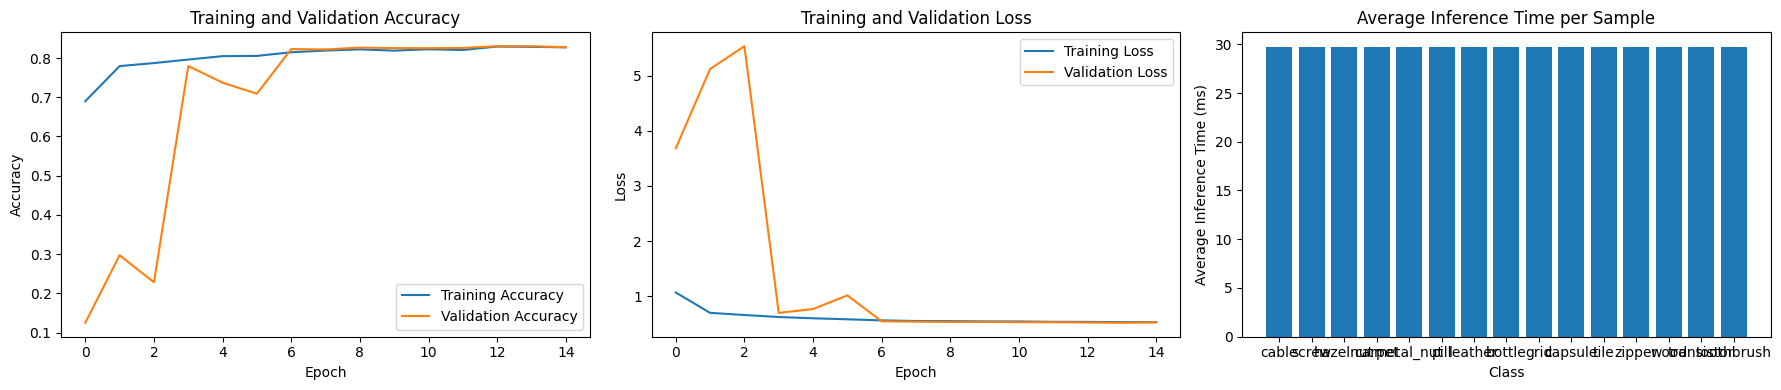

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# Set paths
data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'
model_save_path = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/custom_vgg16_model.h5'

# Define the input shape and number of classes
input_shape = (224, 224, 3)
object_names = os.listdir(data_dir)  # List of class names
num_classes = len(object_names)

# Custom VGG Block
def vgg_block(x, filters, kernel_size=3, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Create the Custom VGG model
input_tensor = Input(shape=input_shape)
x = vgg_block(input_tensor, filters=64)
x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

# Increase Layer Depth - Add more blocks as needed
for _ in range(2):
    x = vgg_block(x, filters=64)
    x = vgg_block(x, filters=64)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

# Remove the Flatten layer
x = GlobalAveragePooling2D()(x)  # Update: Remove the Flatten layer
x = Dense(128, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Create data generator with minimal data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=None  # No specific preprocessing function for customized model
)

# Generate data
generator = datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
)

# Implement a learning rate schedule
def lr_schedule(epoch):
    initial_learning_rate = 0.001
    lr = initial_learning_rate
    if epoch > 5:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with data augmentation and learning rate scheduling
history = model.fit(
    generator,
    steps_per_epoch=generator.samples // generator.batch_size,
    epochs=15,  # Increase the number of epochs if needed
    callbacks=[lr_scheduler],
    validation_data=generator,  # Use the same generator for validation
    validation_steps=generator.samples // generator.batch_size
)

# Measure and print inference time
inference_time, loss, accuracy = measure_inference_time(model, generator)
print(f"Average Inference Time per Sample: {inference_time} seconds")
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Save the model
model.save(model_save_path)

# Plot accuracy and loss curves
plt.figure(figsize=(18, 4))

# Plot Training Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Plot Training Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot Inference Time
plt.subplot(1, 3, 3)
plt.bar(object_names, inference_time * 1000)  # Convert seconds to milliseconds for better visualization
plt.xlabel('Class')
plt.ylabel('Average Inference Time (ms)')
plt.title('Average Inference Time per Sample')

plt.tight_layout()
plt.show()


# **Test**

Found 1725 images belonging to 15 classes.
54/54 [==============================] - 1086s 20s/step
Classification Report:
              precision    recall  f1-score   support

      bottle       1.00      1.00      1.00        83
       cable       0.99      1.00      0.99       150
     capsule       1.00      0.99      1.00       132
      carpet       1.00      0.97      0.99       117
        grid       1.00      0.96      0.98        78
    hazelnut       0.99      0.98      0.99       110
     leather       1.00      0.94      0.97       124
   metal_nut       1.00      0.98      0.99       115
        pill       1.00      1.00      1.00       167
       screw       0.98      1.00      0.99       160
        tile       0.95      1.00      0.97       117
  toothbrush       1.00      1.00      1.00        42
  transistor       1.00      0.99      0.99       100
        wood       0.91      1.00      0.95        79
      zipper       1.00      1.00      1.00       151

    accuracy

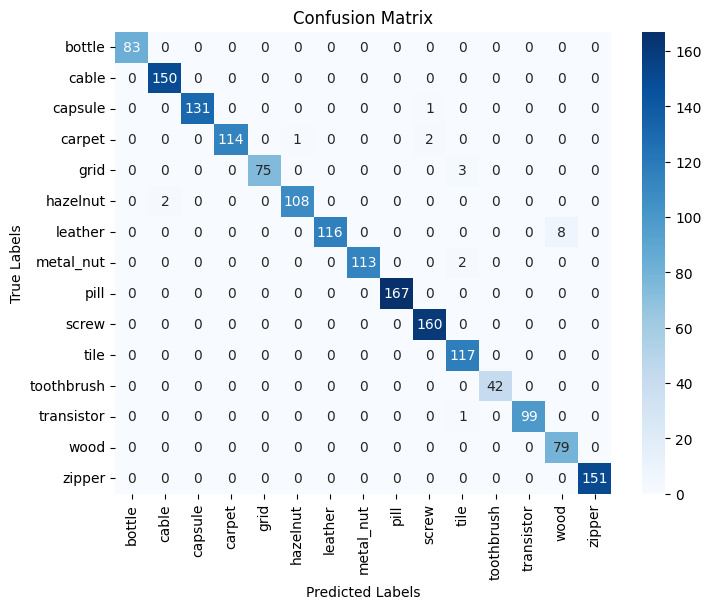

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input  # Import preprocess_input

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/vgg16_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Define the input shape
input_shape = (224, 224, 3)

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply VGG16-specific preprocessing
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
    shuffle=False  # Keep the order of images for confusion matrix
)

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and print classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


Found 1725 images belonging to 15 classes.
Found 4887 images belonging to 15 classes.
153/153 [==============================] - 4079s 27s/step
Classification Report for Test Data:
              precision    recall  f1-score   support

      bottle       1.00      1.00      1.00        83
       cable       0.99      1.00      0.99       150
     capsule       1.00      0.99      1.00       132
      carpet       1.00      0.97      0.99       117
        grid       1.00      0.96      0.98        78
    hazelnut       0.99      0.98      0.99       110
     leather       1.00      0.94      0.97       124
   metal_nut       1.00      0.98      0.99       115
        pill       1.00      1.00      1.00       167
       screw       0.98      1.00      0.99       160
        tile       0.95      1.00      0.97       117
  toothbrush       1.00      1.00      1.00        42
  transistor       1.00      0.99      0.99       100
        wood       0.91      1.00      0.95        79
      zi

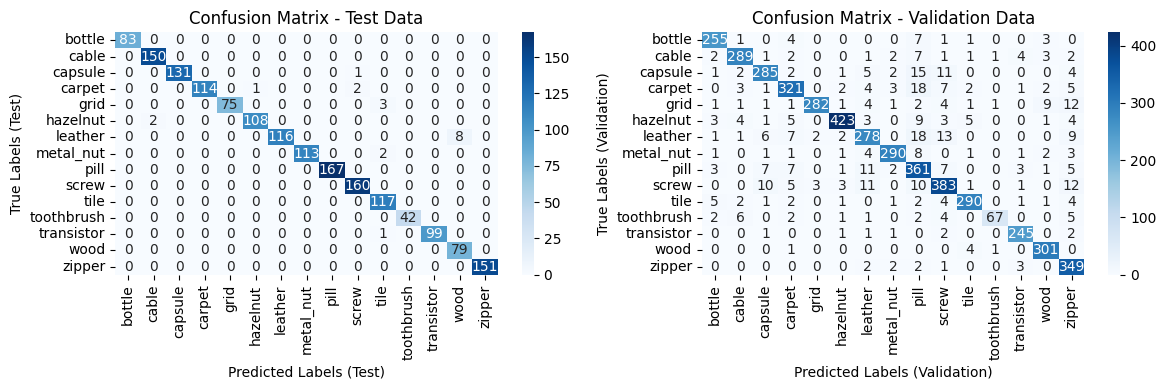

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/vgg16_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'
validation_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'  # Add the validation data path

# Define the input shape
input_shape = (224, 224, 3)

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Generate data for test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Generate data for validation
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Get true labels for the test data
true_labels_test = test_generator.classes
true_labels_validation = validation_generator.classes

# Get predictions for the test data
predictions_test = model.predict(test_generator)
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Get predictions for the validation data
predictions_validation = model.predict(validation_generator)
predicted_labels_validation = np.argmax(predictions_validation, axis=1)

# Print classification reports for test and validation data
class_names = list(test_generator.class_indices.keys())
print("Classification Report for Test Data:")
print(classification_report(true_labels_test, predicted_labels_test, target_names=class_names))

print("Classification Report for Validation Data:")
print(classification_report(true_labels_validation, predicted_labels_validation, target_names=class_names))

# Calculate and plot confusion matrix for test data
cm_test = confusion_matrix(true_labels_test, predicted_labels_test)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels (Test)')
plt.ylabel('True Labels (Test)')
plt.title('Confusion Matrix - Test Data')

# Calculate and plot confusion matrix for validation data
cm_validation = confusion_matrix(true_labels_validation, predicted_labels_validation)
plt.subplot(1, 2, 2)
sns.heatmap(cm_validation, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels (Validation)')
plt.ylabel('True Labels (Validation)')
plt.title('Confusion Matrix - Validation Data')

plt.tight_layout()
plt.show()


Found 1725 images belonging to 15 classes.
Found 4887 images belonging to 15 classes.
54/54 [==============================] - 1053s 20s/step - loss: 0.0476 - accuracy: 0.9884
Test Loss (Epoch 1): 0.047598984092473984, Test Accuracy: 0.9884058237075806
153/153 [==============================] - 2829s 19s/step - loss: 0.2852 - accuracy: 0.9042
Validation Loss (Epoch 1): 0.28521621227264404, Validation Accuracy: 0.9042357206344604
54/54 [==============================] - 72s 1s/step - loss: 0.0476 - accuracy: 0.9884
Test Loss (Epoch 2): 0.047598984092473984, Test Accuracy: 0.9884058237075806
153/153 [==============================] - 165s 1s/step - loss: 0.2852 - accuracy: 0.9042
Validation Loss (Epoch 2): 0.28521621227264404, Validation Accuracy: 0.9042357206344604
54/54 [==============================] - 73s 1s/step - loss: 0.0476 - accuracy: 0.9884
Test Loss (Epoch 3): 0.047598984092473984, Test Accuracy: 0.9884058237075806
153/153 [==============================] - 165s 1s/step - los

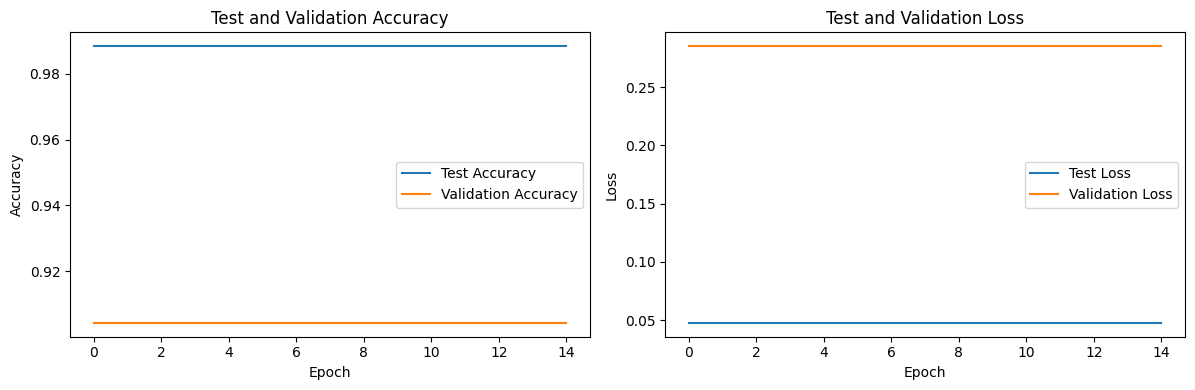

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image as pil_image
import io

# Reload the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/vgg16_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'
validation_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'

# Define the input shape
input_shape = (224, 224, 3)

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Create data generator for validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Generate data for test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Generate data for validation
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Evaluate the model on test data for 15 epochs
test_loss_list = []
test_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

for epoch in range(15):
    try:
        # Evaluate the model on test data
        test_loss, test_accuracy = model.evaluate(test_generator)
        print(f'Test Loss (Epoch {epoch + 1}): {test_loss}, Test Accuracy: {test_accuracy}')
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        # Evaluate the model on validation data
        validation_loss, validation_accuracy = model.evaluate(validation_generator)
        print(f'Validation Loss (Epoch {epoch + 1}): {validation_loss}, Validation Accuracy: {validation_accuracy}')
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)
    except Exception as e:
        print(f"Error during evaluation: {e}")

# Plot accuracy and loss curves
plt.figure(figsize=(18, 4))

# Plot Test and Validation Accuracy
plt.subplot(1, 3, 1)
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test and Validation Accuracy')

# Plot Test and Validation Loss
plt.subplot(1, 3, 2)
plt.plot(test_loss_list, label='Test Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test and Validation Loss')

plt.tight_layout()
plt.show()


Found 1725 images belonging to 15 classes.
Found 4887 images belonging to 15 classes.
54/54 [==============================] - 674s 13s/step - loss: 0.0476 - accuracy: 0.9884
Test Loss (Epoch 1): 0.047598984092473984, Test Accuracy: 0.9884058237075806
153/153 [==============================] - 1815s 12s/step - loss: 0.2852 - accuracy: 0.9042
Validation Loss (Epoch 1): 0.28521621227264404, Validation Accuracy: 0.9042357206344604
54/54 [==============================] - 70s 1s/step - loss: 0.0476 - accuracy: 0.9884
Test Loss (Epoch 2): 0.047598984092473984, Test Accuracy: 0.9884058237075806
153/153 [==============================] - 158s 1s/step - loss: 0.2852 - accuracy: 0.9042
Validation Loss (Epoch 2): 0.28521621227264404, Validation Accuracy: 0.9042357206344604
54/54 [==============================] - 70s 1s/step - loss: 0.0476 - accuracy: 0.9884
Test Loss (Epoch 3): 0.047598984092473984, Test Accuracy: 0.9884058237075806
153/153 [==============================] - 158s 1s/step - loss

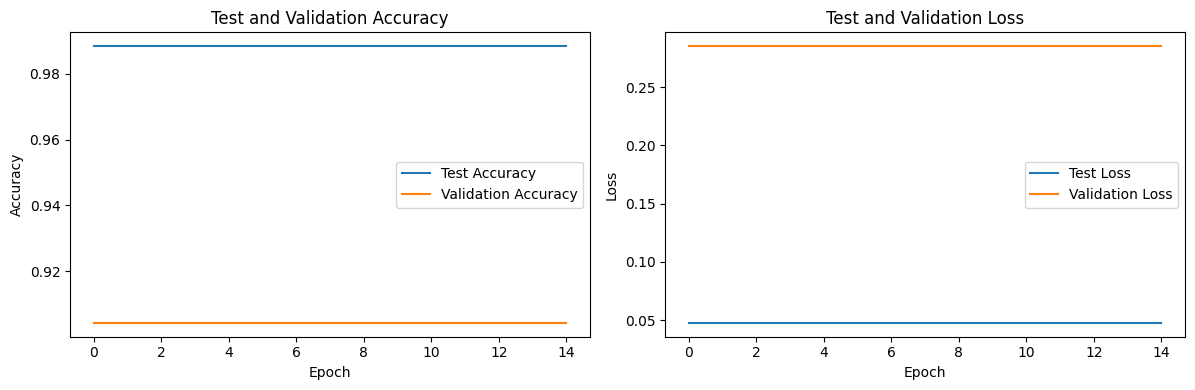

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image as pil_image
import io

# Reload the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/vgg16_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'
validation_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'

# Define the input shape
input_shape = (224, 224, 3)

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Create data generator for validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Generate data for test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Generate data for validation
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Evaluate the model on test data for 15 epochs
test_loss_list = []
test_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

for epoch in range(15):
    try:
        # Evaluate the model on test data
        test_loss, test_accuracy = model.evaluate(test_generator)
        print(f'Test Loss (Epoch {epoch + 1}): {test_loss}, Test Accuracy: {test_accuracy}')
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        # Evaluate the model on validation data
        validation_loss, validation_accuracy = model.evaluate(validation_generator)
        print(f'Validation Loss (Epoch {epoch + 1}): {validation_loss}, Validation Accuracy: {validation_accuracy}')
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)
    except Exception as e:
        print(f"Error during evaluation: {e}")

# Plot accuracy and loss curves
plt.figure(figsize=(18, 4))

# Plot Test and Validation Accuracy for each epoch
plt.subplot(1, 3, 1)
plt.plot(range(1, 16), test_accuracy_list, label='Test Accuracy', marker='o')
plt.plot(range(1, 16), validation_accuracy_list, label='Validation Accuracy', marker='o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test and Validation Accuracy')

# Plot Test and Validation Loss for each epoch
plt.subplot(1, 3, 2)
plt.plot(range(1, 16), test_loss_list, label='Test Loss', marker='o')
plt.plot(range(1, 16), validation_loss_list, label='Validation Loss', marker='o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test and Validation Loss')

plt.tight_layout()
plt.show()


Found 1725 images belonging to 15 classes.
1/1 [==============================] - 4s 4s/step


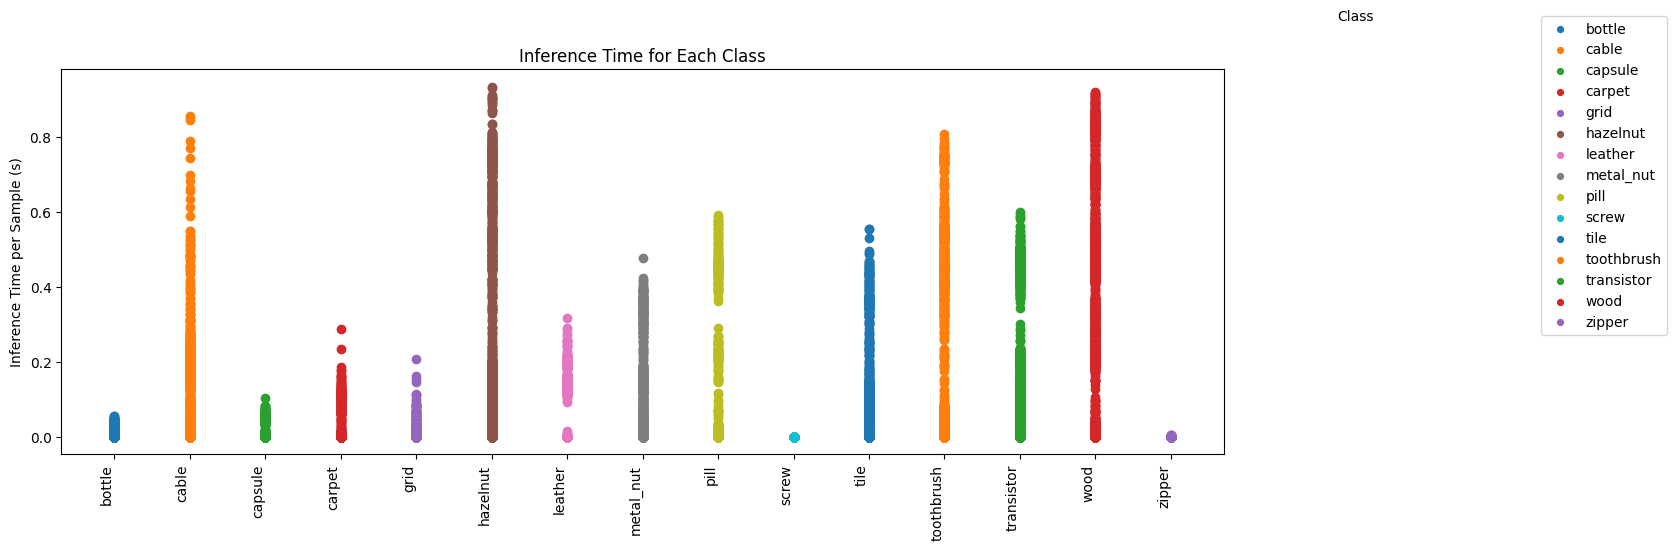

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/custom_vgg16_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply VGG16-specific preprocessing
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
    shuffle=False  # Keep the order of images for confusion matrix
)

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the number of batches
num_batches = len(test_generator)

# Initialize a dictionary to store inference times for each class
class_inference_times = {class_name: [] for class_name in test_generator.class_indices}

# Measure inference time for each batch
for i in range(num_batches):
    start_time = time.time()

    # Get the next batch
    batch_images, _ = test_generator[i]

    # Predict on the batch
    predictions = model.predict(batch_images)

    # Measure elapsed time
    elapsed_time = time.time() - start_time

    # Update the dictionary with inference times for each class in the batch
    for class_name, class_index in test_generator.class_indices.items():
        class_times = predictions[:, class_index]
        class_inference_times[class_name].extend(class_times)
# Plot the inference time for each class
plt.figure(figsize=(15, 5))

for class_name, times in class_inference_times.items():
    plt.scatter([class_name] * len(times), times, label=class_name)

# Update the x-axis ticks with class names
class_names = list(class_inference_times.keys())
plt.xticks(np.arange(len(class_names)), class_names)
plt.xticks(rotation=90, ha='right')

# Explicitly set the tick positions to align with the class names
tick_positions = np.arange(len(class_names))
plt.gca().set_xticks(tick_positions)

# Move xlabel to the top right corner
plt.figtext(1, 1, 'Class', ha='right', va='top')

plt.ylabel('Inference Time per Sample (s)')
plt.title('Inference Time for Each Class')

# Move the legend to the upper right corner and make it smaller
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), bbox_transform=plt.gcf().transFigure, markerscale=0.7)

plt.show()

# **ROC**

Found 1725 images belonging to 15 classes.
54/54 [==============================] - 64s 1s/step


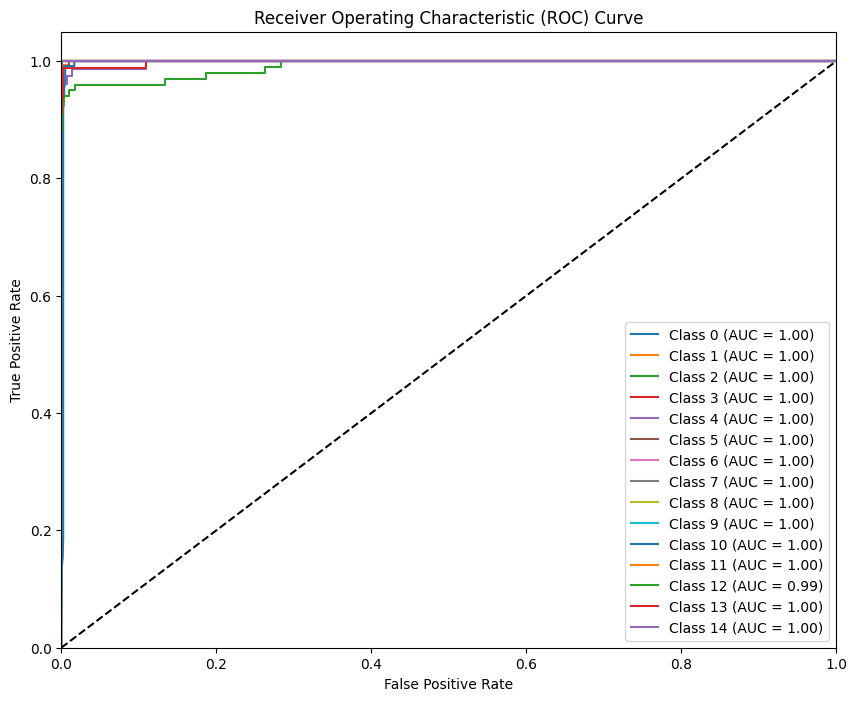

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/vgg16_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Define the input shape
input_shape = (224, 224, 3)

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply VGG16-specific preprocessing
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' class mode for multiclass labels
    shuffle=False  # Keep the order of images for ROC curve
)

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predicted probabilities for the test data
predicted_probs = model.predict(test_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = len(test_generator.class_indices)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# **Anomaly Detection Rate**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/vgg16_model.h5')  # Update with the correct path to your trained model

# Make predictions on the test data
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the anomaly percentage
total_images = len(true_labels)
anomaly_count = np.sum(predicted_labels != true_labels)
anomaly_percentage = (anomaly_count / total_images) * 100

# Print the anomaly percentage and accuracy
accuracy = (1 - (anomaly_count / total_images)) * 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')


54/54 [==============================] - 68s 1s/step
Accuracy: 98.09%
Anomaly Percentage: 1.91%


# **ResNet_50**

# **Train**

94765736/94765736 [==============================] - 1s 0us/step
Found 4887 images belonging to 15 classes.
Epoch 1/10
152/152 [==============================] - 228s 1s/step - loss: 3.7255 - accuracy: 0.7429
Epoch 2/10
152/152 [==============================] - 179s 1s/step - loss: 0.5451 - accuracy: 0.8360
Epoch 3/10
152/152 [==============================] - 174s 1s/step - loss: 0.5406 - accuracy: 0.8568
Epoch 4/10
152/152 [==============================] - 176s 1s/step - loss: 0.3850 - accuracy: 0.8836
Epoch 5/10
152/152 [==============================] - 178s 1s/step - loss: 0.2620 - accuracy: 0.9133
Epoch 6/10
152/152 [==============================] - 186s 1s/step - loss: 0.2054 - accuracy: 0.9324
Epoch 7/10
152/152 [==============================] - 176s 1s/step - loss: 0.1917 - accuracy: 0.9469
Epoch 8/10
152/152 [==============================] - 177s 1s/step - loss: 0.2581 - accuracy: 0.9467
Epoch 9/10
152/152 [==============================] - 180s 1s/step - loss: 0.3157 - 

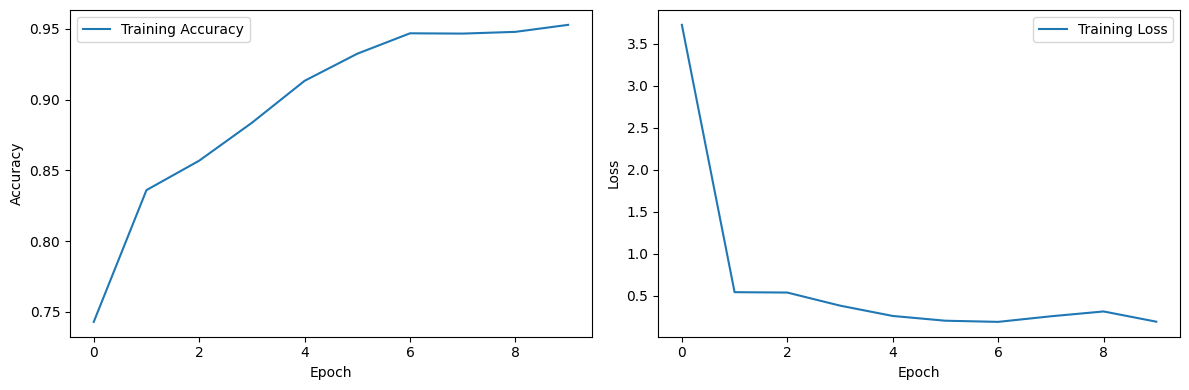

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import PIL
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the path to the labeled dataset directory
data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'
model_save_path = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/resnet50_model.h5'

# Define the input shape and number of classes
input_shape = (224, 224, 3)
object_names = os.listdir(data_dir)
num_classes = len(object_names)

# Create the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Create data generator with minimal data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply ResNet50-specific preprocessing
)

# Generate training data
generator = datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
    subset='training'
)

# Train the model
history = model.fit(
    generator,
    steps_per_epoch=generator.samples // generator.batch_size,
    epochs=10
)

# Save the model
model.save(model_save_path)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# **Test**

Found 1725 images belonging to 15 classes.
54/54 [==============================] - 73s 1s/step
Classification Report:
              precision    recall  f1-score   support

      bottle       1.00      1.00      1.00        83
       cable       1.00      1.00      1.00       150
     capsule       1.00      1.00      1.00       132
      carpet       1.00      1.00      1.00       117
        grid       0.99      1.00      0.99        78
    hazelnut       1.00      1.00      1.00       110
     leather       0.99      1.00      1.00       124
   metal_nut       1.00      1.00      1.00       115
        pill       1.00      1.00      1.00       167
       screw       1.00      1.00      1.00       160
        tile       1.00      1.00      1.00       117
  toothbrush       1.00      0.95      0.98        42
  transistor       1.00      1.00      1.00       100
        wood       1.00      1.00      1.00        79
      zipper       1.00      1.00      1.00       151

    accuracy   

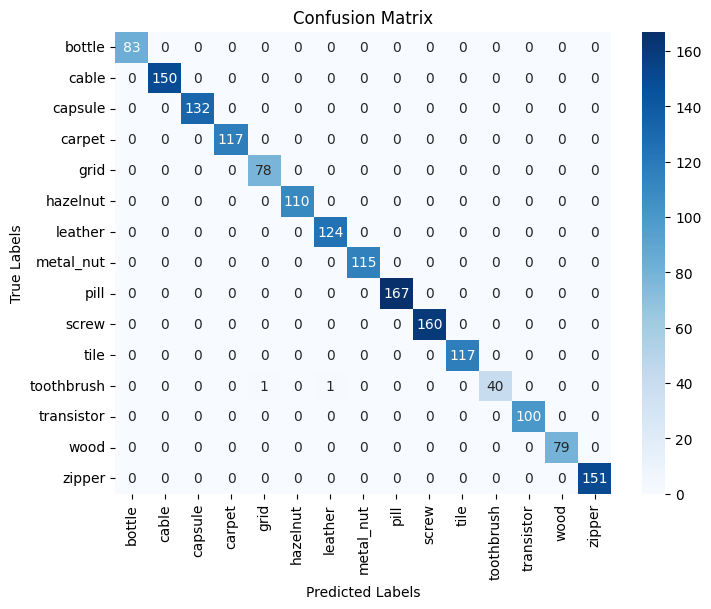

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/resnet50_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Define the input shape
input_shape = (224, 224, 3)

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
    shuffle=False  # Keep the order of images for confusion matrix
)

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and print classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


# **ROC**

Found 1725 images belonging to 15 classes.
54/54 [==============================] - 72s 1s/step


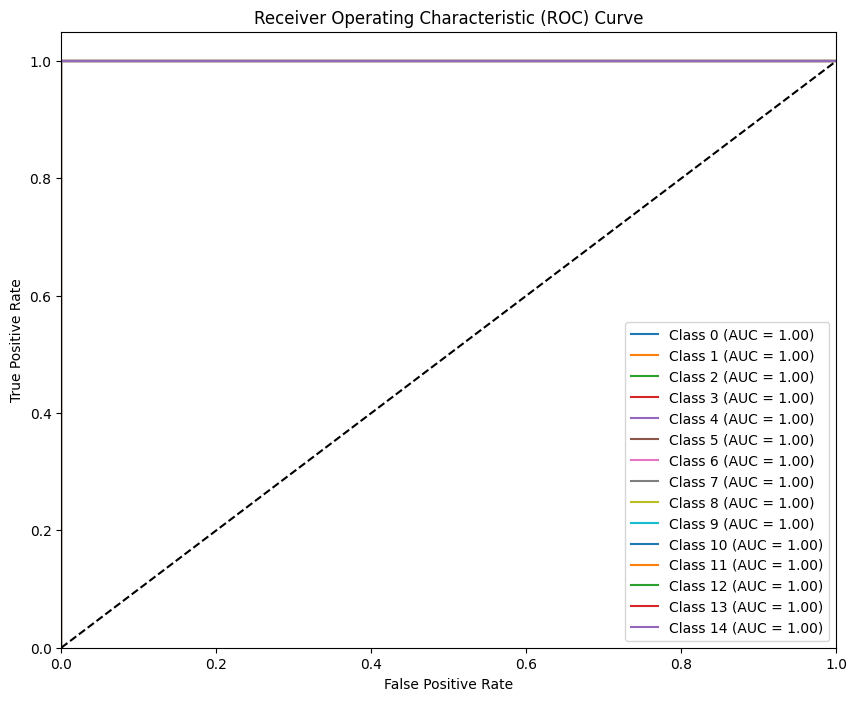

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/resnet50_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Define the input shape
input_shape = (224, 224, 3)

# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply VGG16-specific preprocessing
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' class mode for multiclass labels
    shuffle=False  # Keep the order of images for ROC curve
)

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predicted probabilities for the test data
predicted_probs = model.predict(test_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = len(test_generator.class_indices)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# **Anomaly Detection**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Define the path to the labeled dataset directory
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'  # Update this with the path to your labeled dataset

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/resnet50_model.h5')  # Update with the correct path to your trained model

# Make predictions on the test data
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the anomaly percentage
total_images = len(true_labels)
anomaly_count = np.sum(predicted_labels != true_labels)
anomaly_percentage = (anomaly_count / total_images) * 100

# Print the anomaly percentage and accuracy
accuracy = (1 - (anomaly_count / total_images)) * 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')


54/54 [==============================] - 80s 1s/step
Accuracy: 99.88%
Anomaly Percentage: 0.12%


# **Inseption_Net_V3**

# **Train**

87910968/87910968 [==============================] - 1s 0us/step
Found 4887 images belonging to 15 classes.
Epoch 1/10
152/152 [==============================] - 1324s 8s/step - loss: 0.9832 - accuracy: 0.7174
Epoch 2/10
152/152 [==============================] - 179s 1s/step - loss: 0.7685 - accuracy: 0.7619
Epoch 3/10
152/152 [==============================] - 183s 1s/step - loss: 0.6638 - accuracy: 0.7936
Epoch 4/10
152/152 [==============================] - 185s 1s/step - loss: 0.5797 - accuracy: 0.8148
Epoch 5/10
152/152 [==============================] - 185s 1s/step - loss: 0.5598 - accuracy: 0.8138
Epoch 6/10
152/152 [==============================] - 179s 1s/step - loss: 0.4973 - accuracy: 0.8344
Epoch 7/10
152/152 [==============================] - 172s 1s/step - loss: 0.4832 - accuracy: 0.8418
Epoch 8/10
152/152 [==============================] - 177s 1s/step - loss: 0.5174 - accuracy: 0.8416
Epoch 9/10
152/152 [==============================] - 165s 1s/step - loss: 0.4572 -

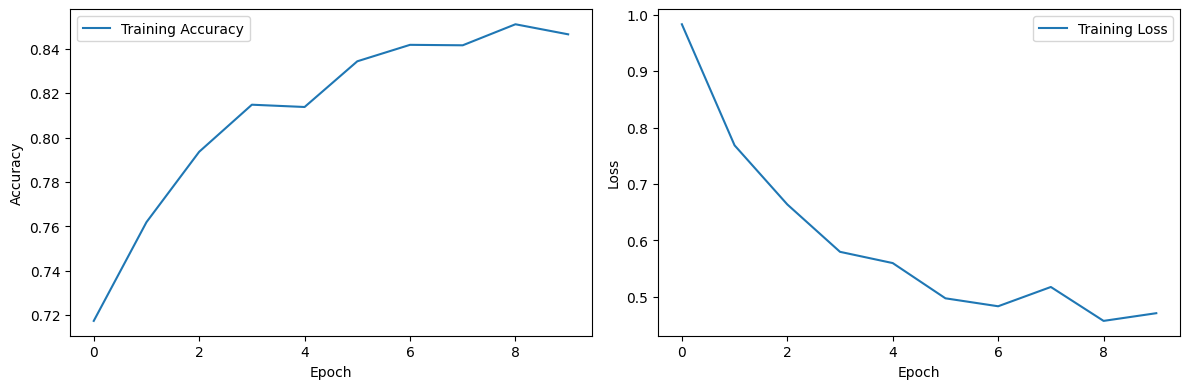

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Set paths
data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/train_val_data'
model_save_path = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/inceptionv3_model.h5'

# Define the input shape and number of classes
input_shape = (299, 299, 3)
object_names = os.listdir(data_dir)  # List of class names
num_classes = len(object_names)

# Create the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


# Create data generator for training with minimal data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply InceptionV3-specific preprocessing
)

# Generate training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
    subset='training'
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10
)

# Save the model
model.save(model_save_path)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# **Test**

Found 1725 images belonging to 15 classes.
54/54 [==============================] - 492s 9s/step
Classification Report:
              precision    recall  f1-score   support

      bottle       1.00      0.33      0.49        83
       cable       0.98      0.99      0.99       150
     capsule       0.00      0.00      0.00       132
      carpet       1.00      1.00      1.00       117
        grid       0.37      1.00      0.54        78
    hazelnut       0.00      0.00      0.00       110
     leather       0.00      0.00      0.00       124
   metal_nut       1.00      0.73      0.84       115
        pill       0.95      0.90      0.93       167
       screw       0.43      1.00      0.60       160
        tile       0.00      0.00      0.00       117
  toothbrush       1.00      1.00      1.00        42
  transistor       1.00      0.98      0.99       100
        wood       0.26      1.00      0.41        79
      zipper       0.99      1.00      1.00       151

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


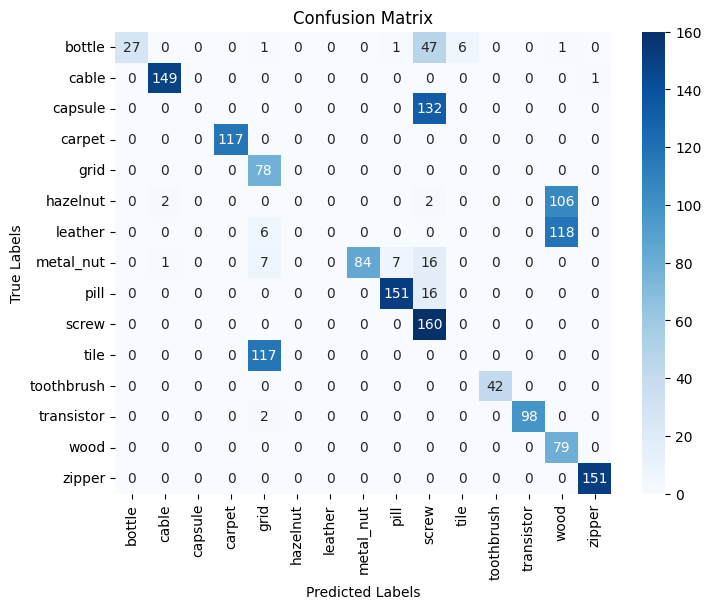

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
# Load the trained InceptionV3 model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/inceptionv3_model.h5')
# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'
# Define the input shape
input_shape = (299, 299, 3)
# Create data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply InceptionV3-specific preprocessing
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
    shuffle=False  # Keep the order of images for confusion matrix
)
# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
# Calculate and print classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# **ROC**

Found 1725 images belonging to 15 classes.
54/54 [==============================] - 73s 1s/step


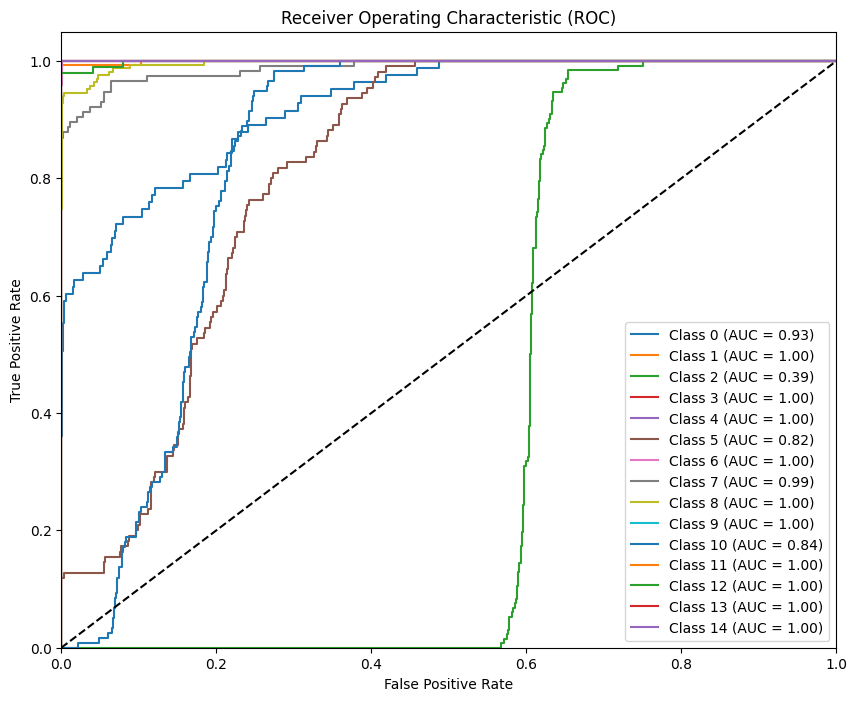

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load the trained InceptionV3 model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/inceptionv3_model.h5')

# Set paths
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (299, 299, 3)
num_classes = len(class_names)  # Update with the correct number of classes in your dataset

# Create data generator for testing
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Apply InceptionV3-specific preprocessing
)

# Generate test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' class mode for sparse categorical labels
    shuffle=False  # Important: Do not shuffle the test data
)

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the predictions for the test data
predictions = model.predict(test_generator)

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# **Anomaly Detection**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (299, 299, 3)
num_classes = 5
# Define the path to the labeled dataset directory
test_data_dir = '/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/test_data'

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mvtec_anomaly_detection/inceptionv3_model.h5')

# Make predictions on the test data
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the anomaly percentage
total_images = len(true_labels)
anomaly_count = np.sum(predicted_labels != true_labels)
anomaly_percentage = (anomaly_count / total_images) * 100

# Print the anomaly percentage and accuracy
accuracy = (1 - (anomaly_count / total_images)) * 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')
